<a href="https://colab.research.google.com/github/Alex0Alca0/Image_processing-/blob/main/RGB_STATS_PARCHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import os 
import numpy as np 
import pandas as pd 
import skimage
import imageio
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import statistics
from scipy.stats import kurtosis
import cv2
import time
import concurrent.futures
import multiprocessing
from multiprocessing import Pool
import itertools
import pickle

#Main Code

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.client import GoogleCredentials

# Autenticar y crear la conexión al API de Drive
auth.authenticate_user()
gauth = GoogleCredentials.get_application_default()
drive_service = build('drive', 'v3', credentials=gauth)

In [ ]:
def boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False):
    r"""
    Return a list of dictionaries of statistics used to draw a series of box
    and whisker plots using `~.Axes.bxp`.
    Parameters
    ----------
    X : array-like
        Data that will be represented in the boxplots. Should have 2 or
        fewer dimensions.
    whis : float or (float, float), default: 1.5
        The position of the whiskers.
        If a float, the lower whisker is at the lowest datum above
        ``Q1 - whis*(Q3-Q1)``, and the upper whisker at the highest datum below
        ``Q3 + whis*(Q3-Q1)``, where Q1 and Q3 are the first and third
        quartiles.  The default value of ``whis = 1.5`` corresponds to Tukey's
        original definition of boxplots.
        If a pair of floats, they indicate the percentiles at which to draw the
        whiskers (e.g., (5, 95)).  In particular, setting this to (0, 100)
        results in whiskers covering the whole range of the data.
        In the edge case where ``Q1 == Q3``, *whis* is automatically set to
        (0, 100) (cover the whole range of the data) if *autorange* is True.
        Beyond the whiskers, data are considered outliers and are plotted as
        individual points.
    bootstrap : int, optional
        Number of times the confidence intervals around the median
        should be bootstrapped (percentile method).
    labels : array-like, optional
        Labels for each dataset. Length must be compatible with
        dimensions of *X*.
    autorange : bool, optional (False)
        When `True` and the data are distributed such that the 25th and 75th
        percentiles are equal, ``whis`` is set to (0, 100) such that the
        whisker ends are at the minimum and maximum of the data.
    Returns
    -------
    list of dict
        A list of dictionaries containing the results for each column
        of data. Keys of each dictionary are the following:
        ========   ===================================
        Key        Value Description
        ========   ===================================
        label      tick label for the boxplot
        mean       arithmetic mean value
        med        50th percentile
        q1         first quartile (25th percentile)
        q3         third quartile (75th percentile)
        iqr        interquartile range
        cilo       lower notch around the median
        cihi       upper notch around the median
        whislo     end of the lower whisker
        whishi     end of the upper whisker
        fliers     outliers
        ========   ===================================
    Notes
    -----
    Non-bootstrapping approach to confidence interval uses Gaussian-based
    asymptotic approximation:
    .. math::
        \mathrm{med} \pm 1.57 \times \frac{\mathrm{iqr}}{\sqrt{N}}
    General approach from:
    McGill, R., Tukey, J.W., and Larsen, W.A. (1978) "Variations of
    Boxplots", The American Statistician, 32:12-16.
    """

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksiness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['iqr'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # medians and quartiles
        q1, med, q3 = np.percentile(x, [25, 50, 75])

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = (0, 100)

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.iterable(whis) and not isinstance(whis, str):
            loval, hival = np.percentile(x, whis)
        elif np.isreal(whis):
            loval = q1 - whis * stats['iqr']
            hival = q3 + whis * stats['iqr']
        else:
            raise ValueError('whis must be a float or list of percentiles')

        # get high extreme
        wiskhi = x[x <= hival]
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
            
        else:
            stats['whishi'] = np.max(wiskhi)
            
        # get low extreme
        wisklo = x[x >= loval]
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
            
        else:
            stats['whislo'] = np.min(wisklo)
            
        # compute a single array of outliers
        stats['fliers'] = np.concatenate([
            x[x < stats['whislo']],
            x[x > stats['whishi']],
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats
def _unpack_to_numpy(x):
    """Internal helper to extract data from e.g. pandas and xarray objects."""
    if isinstance(x, np.ndarray):
        # If numpy, return directly
        return x
    if hasattr(x, 'to_numpy'):
        # Assume that any to_numpy() method actually returns a numpy array
        return x.to_numpy()
    if hasattr(x, 'values'):
        xtmp = x.values
        # For example a dict has a 'values' attribute, but it is not a property
        # so in this case we do not want to return a function
        if isinstance(xtmp, np.ndarray):
            return xtmp
    return x
def _reshape_2D(X, name):
    """
    Use Fortran ordering to convert ndarrays and lists of iterables to lists of
    1D arrays.
    Lists of iterables are converted by applying `numpy.asanyarray` to each of
    their elements.  1D ndarrays are returned in a singleton list containing
    them.  2D ndarrays are converted to the list of their *columns*.
    *name* is used to generate the error message for invalid inputs.
    """

    # Unpack in case of e.g. Pandas or xarray object
    X = _unpack_to_numpy(X)

    # Iterate over columns for ndarrays.
    if isinstance(X, np.ndarray):
        X = X.T

        if len(X) == 0:
            return [[]]
        elif X.ndim == 1 and np.ndim(X[0]) == 0:
            # 1D array of scalars: directly return it.
            return [X]
        elif X.ndim in [1, 2]:
            # 2D array, or 1D array of iterables: flatten them first.
            return [np.reshape(x, -1) for x in X]
        else:
            raise ValueError(f'{name} must have 2 or fewer dimensions')

    # Iterate over list of iterables.
    if len(X) == 0:
        return [[]]

    result = []
    is_1d = True
    for xi in X:
        # check if this is iterable, except for strings which we
        # treat as singletons.
        if not isinstance(xi, str):
            try:
                iter(xi)
            except TypeError:
                pass
            else:
                is_1d = False
        xi = np.asanyarray(xi)
        nd = np.ndim(xi)
        if nd > 1:
            raise ValueError(f'{name} must have 2 or fewer dimensions')
        result.append(xi.reshape(-1))

    if is_1d:
        # 1D array of scalars: directly return it.
        return [np.reshape(result, -1)]
    else:
        # 2D array, or 1D array of iterables: use flattened version.
        return result

def get_filenames(Img_Sur, extension):
  """
  Función que permite obtener los nombres de archivos de una lista de nombres de archivos, 
  filtrándolos por una extensión específica.

  Parámetros:
  Img_Sur (list): Lista de nombres de archivos.
  extension (str): Extensión a filtrar.
  
  Retorna:
  list: Lista de nombres de archivos filtrados por la extensión especificada.
  """
  file_names = [file_name for file_name in Img_Sur if file_name[-3:] == extension]
  file_names.sort()
  return file_names

def vectRGB_S (args):
  """
  Función que permite extraer los valores a nivel pixel de los tres distintos 
  canales (RGB) de una imagen comparandola a una mascara.

  Parámetros:
  path: Inicio de la dirección. (Ejemplo: 'omarlopez/Escritorio/')
  Img: Imagen que se desea extraer el valor de los pixeles. 
  Img_Lbl: Mascara de las imagenes.

  Retorna: Tres Vectores R,G,B.
  """
  path, Img, Img_Lbl = args

  Img_Lbl = imageio.imread(path+Img_Lbl)
  Img = imageio.imread(path+Img)
  
  r,g,b = Img[:,:,0], Img[:,:,1], Img[:,:,2]

  idx = (Img_Lbl == 1)
  Vr = r[idx].flatten()
  Vg = g[idx].flatten()
  Vb = b[idx].flatten()
  
  return Vr, Vg, Vb

def vectRGB_S_ (path,Img, Img_Lbl):
  """
  Función que permite extraer los valores a nivel pixel de los tres distintos 
  canales (RGB) de una imagen comparandola a una mascara.

  Parámetros:
  path: Inicio de la dirección. (Ejemplo: 'omarlopez/Escritorio/')
  Img: Imagen que se desea extraer el valor de los pixeles. 
  Img_Lbl: Mascara de las imagenes.

  Retorna: Tres Vectores R,G,B.
  """

  Img_Lbl = imageio.imread(path+Img_Lbl)
  Img = imageio.imread(path+Img)
  
  r,g,b = Img[:,:,0], Img[:,:,1], Img[:,:,2]

  idx = (Img_Lbl == 1)
  Vr = r[idx].flatten()
  Vg = g[idx].flatten()
  Vb = b[idx].flatten()
  
  return Vr, Vg, Vb

In [ ]:
#Lo que hace esta función es poner en un arreglo todos los valores de los pixeles 1xn 
#pero son listas de listas, es decir, cada posición es una [img1= 1xn][img2=1xn_1][img_3=1xn_2][img_4=1xn_3][img_4=1xn_4]
def vectRGB (args):

  path, Img = args

  Img = imageio.imread(path+'/'+Img)

  r,g,b = Img[:,:,0], Img[:,:,1], Img[:,:,2]
  Vr = r.flatten()
  Vg = g.flatten()
  Vb = b.flatten()

  return Vr, Vg, Vb

In [ ]:
def process_data(data):
    return boxplot_stats(data)

In [ ]:
folder_name = "RGB_STATS_PARCHE"
mime_type = "application/vnd.google-apps.folder"

# Crear metadata de la carpeta
file_metadata = {
    "name": folder_name,
    "mimeType": mime_type
}

# Crear la carpeta en Drive
folder = drive_service.files().create(body=file_metadata, fields="id").execute()

# Obtener el ID de la carpeta
folder_id = folder.get("id")

# Imprimir el ID de la carpeta
print("ID de la carpeta creada:", folder_id)

ID de la carpeta creada: 1A-h5bZkJ9VFdcBCxPoYY4M-fy-CaqhCf


#Codigo

In [ ]:
main_path = '/content/drive/MyDrive/jonathan_patch/'
path_sec = main_path + 'SEC/'
path_sur = main_path + 'SUR/'
path_sec_list = os.listdir(path_sec)
path_sur_list = os.listdir(path_sur)

In [ ]:
resultados = {}
for i in range(len(path_sec_list)):
    paso = path_sec + path_sec_list[i] + '/'
    _Img_ = os.listdir(path_sec + path_sec_list[i])
    args = [(paso, png) for png in get_filenames(_Img_, 'png')]
    with Pool(processes=5) as pool:
        result = pool.map(vectRGB, args)

    VR, VG, VB = zip(*result)
    VR_1_T = np.concatenate(VR)
    VG_1_T = np.concatenate(VG)
    VB_1_T = np.concatenate(VB)

    resultados[path_sec_list[i]] = [VR_1_T, VG_1_T, VB_1_T]

In [ ]:
keys = ['SEC-Subtype_IVc', 'SEC-Subtype_IIIa', 'SEC-Subtype_Ia', 'SEC-Subtype_IVd', 'SEC-Subtype_IIa', 'SEC-Subtype_Va']
R_ = {}
G_ = {}
B_ = {}
stats_R = {}
stats_G = {}
stats_B = {}

for key in keys:
    R_[key] = np.concatenate((resultados[key][0], resultados[key+'_1'][0]), axis=None)
    #R_[key] = data
    #stats_R[key] = boxplot_stats(data)
  
for key in keys:
    G_[key]= np.concatenate((resultados[key][1], resultados[key+'_1'][1]), axis=None)
    #G_[key] = data
    #stats_G[key] = boxplot_stats(data)

for key in keys:
    B_[key] = np.concatenate((resultados[key][2], resultados[key+'_1'][2]), axis=None)
    #B_[key] = data
    #stats_B[key] = boxplot_stats(data)

In [ ]:
with open("/content/drive/MyDrive/RGB_STATS_PARCHE/resultados_RGB_Parche_SEC.pickle", "wb") as file:
    pickle.dump(resultados, file)

In [ ]:
del stats_R, stats_G

In [ ]:
del stats_B

In [ ]:
del resultados
del VR_1_T, VG_1_T, VB_1_T
del result
del VR, VG, VB
del args

In [ ]:
IVc = [R_[keys[0]],G_[keys[0]],B_[keys[0]]]
IIIa = [R_[keys[1]],G_[keys[1]],B_[keys[1]]]
Ia = [R_[keys[2]],G_[keys[2]],B_[keys[2]]]
IVd = [R_[keys[3]],G_[keys[3]],B_[keys[3]]]
IIa = [R_[keys[4]],G_[keys[4]],B_[keys[4]]]
Va = [R_[keys[5]],G_[keys[5]],B_[keys[5]]]

In [ ]:
del R_, G_, B_

In [ ]:
with Pool(processes=5) as pool:
  result = pool.map(vectRGB, args)

In [ ]:
stats_IIIa=boxplot_stats(IIIa)
stats_IIa=boxplot_stats(IIa)
stats_Va=boxplot_stats(Va)
stats_Ia=boxplot_stats(Ia)
stats_IVc=boxplot_stats(IVc)
stats_IVd=boxplot_stats(IVd)

In [ ]:
labels_= ["(AU)","(WD)","(CYS)","(WW)","(STR)","(BRU)"]


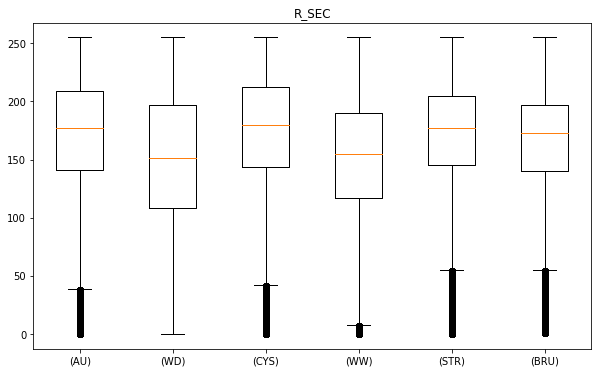

In [ ]:
title_1= "R_SEC"
plt.figure(figsize=(10,6))
plt.title(title_1)
plt.boxplot([IIIa[0],IIa[0],Va[0],Ia[0],IVc[0],IVd[0]],labels=labels_)
plt.savefig("/content/drive/MyDrive/RGB_STATS_PARCHE/R_SEC.png")

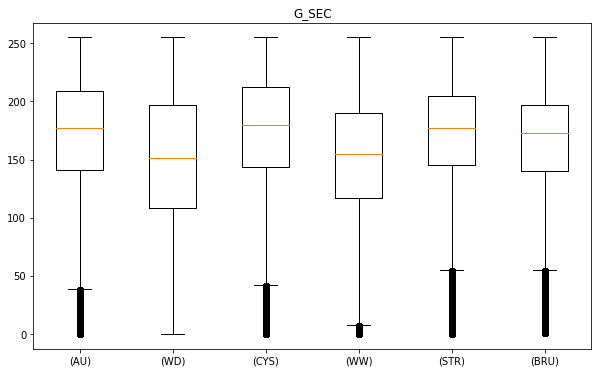

In [ ]:
title_2 = "G_SEC"
plt.figure(figsize=(10,6))
plt.title(title_2)
plt.boxplot([IIIa[0],IIa[0],Va[0],Ia[0],IVc[0],IVd[0]],labels=labels_)
plt.savefig("/content/drive/MyDrive/RGB_STATS_PARCHE/G_SEC.png")

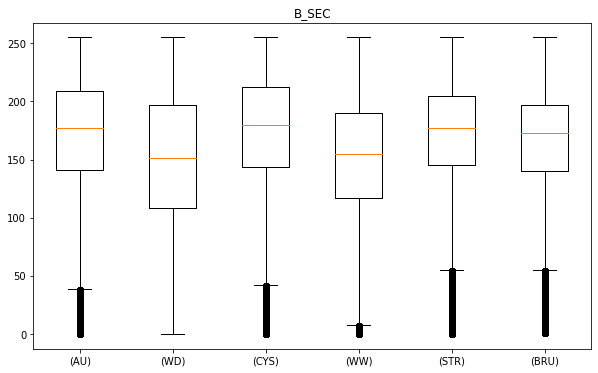

In [ ]:
title_3 = "B_SEC"
plt.figure(figsize=(10,6))
plt.title(title_3)
plt.boxplot([IIIa[0],IIa[0],Va[0],Ia[0],IVc[0],IVd[0]],labels=labels_)
plt.savefig("/content/drive/MyDrive/RGB_STATS_PARCHE/B_SEC.png")

#Visualización

In [ ]:
stats_IVc

[{'mean': 173.00054225158692,
  'iqr': 60.0,
  'cilo': 176.98836380642234,
  'cihi': 177.01163619357766,
  'whishi': 255,
  'whislo': 55,
  'fliers': array([22, 25, 23, ..., 50, 51, 53], dtype=uint8),
  'q1': 145.0,
  'med': 177.0,
  'q3': 205.0},
 {'mean': 161.89594921875,
  'iqr': 58.0,
  'cilo': 164.9887516795416,
  'cihi': 165.0112483204584,
  'whishi': 255,
  'whislo': 48,
  'fliers': array([21, 22, 23, ..., 44, 45, 47], dtype=uint8),
  'q1': 135.0,
  'med': 165.0,
  'q3': 193.0},
 {'mean': 136.44339213562012,
  'iqr': 57.0,
  'cilo': 136.98894561610123,
  'cihi': 137.01105438389877,
  'whishi': 252,
  'whislo': 25,
  'fliers': array([ 16,  17,  15, ..., 255, 255, 254], dtype=uint8),
  'q1': 110.0,
  'med': 137.0,
  'q3': 167.0}]